In [ ]:
!nvidia-smi

Fri Jul  1 14:56:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preparation

In [ ]:
# For Colab only!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

In [ ]:
all_data = []
if os.getcwd().split("\\")[len(os.getcwd().split("\\")) - 1] != "data":
    os.chdir('/content/drive/MyDrive/BA/data')

for f in os.listdir():
    # print(f)
    part_id = f.split("_")[1].split(".")[0]
    # print(part_id)
    df = pd.read_csv(f, sep=";")
    df["part_id"] = part_id
    all_data.append(df)

In [ ]:
all_data[0].head()

,timestamp,active,xPos,yPos,TargetX,StartX,TunnelAmplitude,TunnelWidth,YDistanceToTop,YDistanceToBottom,part_id
0,1651594672586,0,0,0,356.5,1563.5,1207,45,-442.0,487.0,95528384
1,1651594672604,0,976,929,356.5,1563.5,1207,45,411.5,-366.5,95528384
2,1651594672620,0,976,929,356.5,1563.5,1207,45,411.5,-366.5,95528384
3,1651594672631,0,976,929,356.5,1563.5,1207,45,411.5,-366.5,95528384
4,1651594672653,0,976,929,356.5,1563.5,1207,45,411.5,-366.5,95528384


## Normalize by Screensize

In [ ]:
import copy

In [ ]:
def normalize_by_screen(datapoint, screenwidth, screenheight):
    normalized = copy.deepcopy(datapoint)
    normalized["xPos"] /= screenwidth
    normalized["TargetX"] /= screenwidth
    normalized["StartX"] /= screenwidth
    normalized["TunnelAmplitude"] /= screenwidth
    normalized["yPos"] /= screenheight
    normalized["TunnelWidth"] /= screenheight
    normalized["YDistanceToTop"] /= screenheight
    normalized["YDistanceToBottom"] /= screenheight
    return normalized

In [ ]:
def get_participants_screensize(datapoint):
    x_res = -1
    y_res = -1
    # print(datapoint)
    curr_part_id = datapoint["part_id"][0]
    # print(part_id)
    for f in os.listdir():
        curr_id = f.split("_")[1].split(".")[0]
        if curr_id == curr_part_id:
            demographic = pd.read_csv(f, sep=";")
            real_res_string = demographic["Real Res"][0]
            real_res_string = real_res_string.replace("px", "")
            x_res = real_res_string.split(" x ")[0]
            y_res = real_res_string.split(" x ")[1]
    return int(x_res), int(y_res)

In [ ]:
def normalize_screensize(dataset):
    if os.getcwd().split("\\")[len(os.getcwd().split("\\")) - 1] != "demographic_data":
        os.chdir("/content/drive/MyDrive/BA/demographic_data")
    for i, datapoint in enumerate(dataset):
        screenwidth, screenheight = get_participants_screensize(datapoint)
        dataset[i] = normalize_by_screen(datapoint, screenwidth, screenheight)

## First Order Derivation

In [ ]:
def get_data_with_derivate(datapoint):
    diffSeries = datapoint["xPos"].diff(periods=1)
    datapoint.insert(3, "xSpeed", diffSeries)
    diffSeries = datapoint["yPos"].diff(periods=1)
    datapoint.insert(5, "ySpeed", diffSeries)

## To np Array

In [ ]:
import numpy as np

In [ ]:
def get_np_arrays(data):
    data_array = []
    for curr in data:
        removed = copy.deepcopy(curr)
        removed = removed.drop('timestamp', axis=1)
        removed = removed.drop('xPos', axis=1)
        removed = removed.drop('yPos', axis=1)
        removed = removed.drop('part_id', axis=1)
        data_array.append(removed.to_numpy(copy=True))
    return data_array

## Split into sections

In [ ]:
def append_samples_of_length_n(participant_data, n, samples, labels, label_distance):
    for i in range(participant_data.shape[0] - (n+label_distance)):
        samples.append(copy.deepcopy(participant_data[i:i+n]))
        sum_to_label = np.array([0,0], dtype='float64')
        for j in range (i+n, i+n+label_distance):
            sum_to_label += participant_data[j][1:3]
        labels.append(copy.deepcopy(sum_to_label))
        # labels.append(copy.deepcopy(participant_data[i+n+label_distance][1:3]))

In [ ]:
def get_samples_and_labels(data_array, N=10, label_distance=10):
    samples = []
    labels = []
    for participant_data in data_array:
        append_samples_of_length_n(participant_data, N, samples, labels, label_distance)
    return samples, labels

## Remove unusable

In [ ]:
def remove_unusable(data, labels, verbose=0):
    # print(labels)
    new_data = []
    new_labels = []
    for i, sample in enumerate(data):
        bool_array = np.all(sample == sample[0,:], axis=0)
        if bool_array[1] == False or bool_array[2] == False:
            if labels[i][0] != 0:
                new_data.append(sample)
                new_labels.append(labels[i])
        if verbose > 1 and i % 100000 == 0:
            print(f'evaluated {i}')

    if verbose > 0:
        print(f'removed {len(data) - len(new_data)} samples')

    return new_data, new_labels

## Make face the same way

In [ ]:
def make_same_orientation(data, labels, verbose=0):
    changed = 0
    for i, sample in enumerate(data):
        average_x_speed = np.average(sample, axis=0)[1]
        if average_x_speed < 0:
            # print(sample[:, 1])
            sample[:, 1] *= -1
            # print(labels[i])
            # print(labels[i][0])
            labels[i][0] *= -1
            if verbose > 0:
                changed += 1
    if verbose > 0:
        print(f'Changed {changed} samples')

## Total transformation

In [ ]:
def get_transformed_data(dataset, N, label_distance, verbose):
    normalize_screensize(dataset)

    if'xSpeed' not in dataset[0].columns:
        for datapoint in dataset:
            get_data_with_derivate(datapoint)
            datapoint.drop(index=0, axis=0, inplace=True)

    data_array = get_np_arrays(dataset)

    samples, labels = get_samples_and_labels(data_array, N, label_distance)

    samples, labels = remove_unusable(samples, labels, verbose=verbose)

    make_same_orientation(samples, labels, verbose=verbose)

    return samples, labels

## Train-Test-Split

In [ ]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 1.0 - TRAIN_SPLIT

In [ ]:
import random as rand
SEED = 27255

In [ ]:
def get_train_test_split_data(dataset):
    train_data_amount = 0.8 * len(dataset)

    train_data = []
    test_data = []

    rand.seed(SEED)
    train_indizes = rand.sample(range(len(dataset)), int(train_data_amount))
    # print(train_indizes)

    for i, sample in enumerate(dataset):
        if i in train_indizes:
            train_data.append(sample)
        else:
            test_data.append(sample)

    # print(len(train_data))
    # print(len(test_data))

    return train_data, test_data

## Normalize

In [ ]:
def get_average_array(arr, axis=(0,1)):
    return np.mean(arr, axis=axis)

In [ ]:
def get_normalized_arrays(train_samples, train_labels, test_samples, test_labels):
    #avg_array = get_average_array(train_samples)
    # print(avg_array)
    #avg_label_array = get_average_array(train_labels, 0)

    train_array = np.array(train_samples)
    test_array = np.array(test_samples)
    train_labels_array = np.array(train_labels)
    test_labels_array = np.array(test_labels)

    #train_normalized = train_array[:, :, ] / avg_array
    #train_normalized[:, : , 0] = train_array[:, :, 0]
    #train_normalized[:, :, 2] = train_array[:, :, 2]

    #test_normalized = test_array[:, :, ] / avg_array
    #test_normalized[:, :, 0] = test_array[:, :, 0]
    #test_normalized[:, :, 2] = test_array[:, :, 2]

    # train_labels_array[:, 0] /= avg_label_array[0:1] - averages are very low!

    # test_labels_array[:, 0] /= avg_label_array[0:1]

    return train_array, train_labels_array, test_array, test_labels_array

## Get Shuffled Data

In [ ]:
from sklearn.utils import shuffle

In [ ]:
VERBOSE = 1
LABEL_DISTANCE = 6 # 6 => 100ms

def get_preprocessed_data(N):
    curr_data = copy.deepcopy(all_data)
    train_data, test_data = get_train_test_split_data(curr_data)

    train_samples, train_labels = get_transformed_data(train_data, N, LABEL_DISTANCE, 0)
    test_samples, test_labels = get_transformed_data(test_data, N, LABEL_DISTANCE, 0)

    train_samples, train_labels, test_samples, test_labels = get_normalized_arrays(train_samples, train_labels, test_samples, test_labels)

    train_samples, train_labels = shuffle(train_samples, train_labels, random_state=SEED)
    test_samples, test_labels = shuffle(test_samples, test_labels, random_state=SEED)

    return train_samples, train_labels, test_samples, test_labels

# Signal To Noise Ratio Metric

Following: https://stackoverflow.com/questions/68598751/noise-to-signal-ratio-custom-loss-function-in-keras-not-working

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def noiseToSignalLoss(y_true, y_pred):
    losses = tf.math.divide(
        tf.math.reduce_sum(
            tf.math.pow(
               tf.math.subtract(y_true, y_pred)
            , 2)
        , axis=-1),
        tf.math.reduce_sum(
            tf.math.pow(y_true, 2)
        , axis=-1)
    )

    return tf.reduce_mean(losses, axis=-1)

# Fully Connected ANNs

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 40 kB 7.3 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
EPOCHS = 100

In [ ]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

In [ ]:
def get_model(train_x):
    number_of_inputs = train_x.shape[1]

    model = keras.Sequential()
    model.add(
        layers.Input(shape=(number_of_inputs, ))
    )

    model.add(
        layers.Dense(134, activation='tanh')
    )

    model.add(
        layers.Dense(112, activation='tanh')
    )

    model.add(
        layers.Dense(90, activation='tanh')
    )

    model.add(
        layers.Dense(223, activation='tanh')
    )

    model.add(
        layers.Dense(199, activation='tanh')
    )

    model.add(
        layers.Dense(100, activation='tanh')
    )

    model.add(
        layers.Dense(145, activation='tanh')
    )

    model.add(
        layers.Dense(160, activation='tanh')
    )

    model.add(
        layers.Dense(231, activation='tanh')
    )

    model.add(
        layers.Dense(83, activation='tanh')
    )

    model.add(
        layers.Dense(182, activation='tanh')
    )

    model.add(
        layers.Dense(147, activation='tanh')
    )

    model.add(
        layers.Dense(165, activation='tanh')
    )

    model.add(
        layers.Dense(134, activation='tanh')
    )

    model.add(
        layers.Dense(139, activation='tanh')
    )

    model.add(
        layers.Dense(244, activation='tanh')
    )

    model.add(
        layers.Dense(194, activation='tanh')
    )
    
    model.add(layers.Dropout(0.2296))

    model.add(layers.Dense(2, activation='linear'))

    return model

In [ ]:
def get_data():
    train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(6)
    train_samples = train_samples.reshape(train_samples.shape[0], train_samples.shape[1] * train_samples.shape[2])
    test_samples = test_samples.reshape(test_samples.shape[0], test_samples.shape[1] * test_samples.shape[2])

    return train_samples, train_labels, test_samples, test_labels

In [ ]:
def plot_train_vs_val(history, key, model_name):
    plt.figure()
    plt.plot(history.history[key], c='blue')
    plt.plot(history.history['val_'+key], c='black')
    plt.title(f'{model_name} - {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # plt.xlim([0, 100])
    plt.show()

In [ ]:
def plot_all(history, model_name):
    keys = history.history.keys()
    print(keys)
    for key in keys:
        split_key = key.split('_')
        if split_key[0] != 'val':
          plot_train_vs_val(history, key, model_name)

In [ ]:
train_X, train_Y, test_X, test_Y = get_data()

In [ ]:
model = get_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=9.91390e-05), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history = model.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
4060/4060 [==============================] - 28s 6ms/step - loss: 0.0148 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0454 - mean_absolute_error: 0.0148 - noiseToSignalLoss: 23.6524 - val_loss: 0.0133 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.0133 - val_noiseToSignalLoss: 13.6244
Epoch 2/100
4060/4060 [==============================] - 24s 6ms/step - loss: 0.0133 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0133 - noiseToSignalLoss: 14.8453 - val_loss: 0.0132 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.0132 - val_noiseToSignalLoss: 12.0567
Epoch 3/100
4060/4060 [==============================] - 25s 6ms/step - loss: 0.0130 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0130 - noiseToSignalLoss: 13.9497 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_me

In [ ]:
preds = model.predict(test_X[:1000], batch_size=1)

preds

array([[2.93712355e-02, 1.84558710e-04],
       [2.50306949e-02, 2.40105204e-03],
       [1.03956880e-02, 4.60057963e-05],
       ...,
       [1.02014905e-02, 1.31744237e-04],
       [1.18017364e-02, 1.73750828e-04],
       [4.79072798e-03, 1.64128991e-03]], dtype=float32)

In [ ]:
model.evaluate(test_X, test_Y)

16038/16038 [==============================] - 46s 3ms/step - loss: 0.0097 - mean_squared_error: 9.2927e-04 - root_mean_squared_error: 0.0305 - mean_absolute_error: 0.0097 - noiseToSignalLoss: 8.6182


[0.009719306603074074,
 0.0009292706963606179,
 0.030483940616250038,
 0.009719306603074074,
 8.618175506591797]

dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


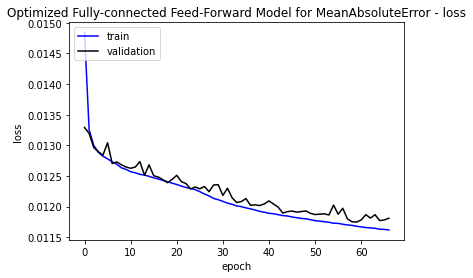

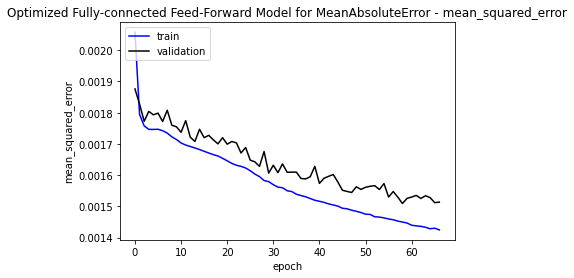

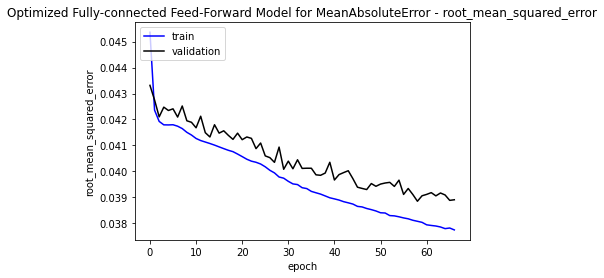

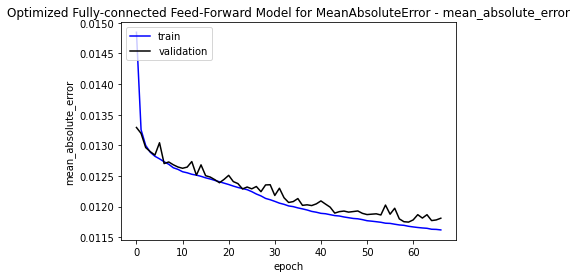

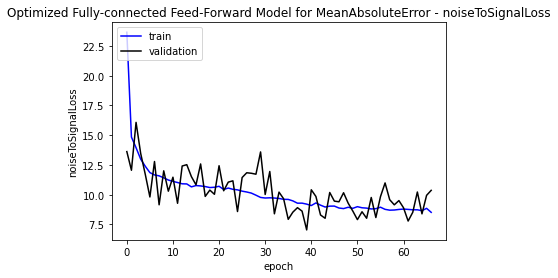

In [ ]:
plot_all(history, 'Optimized Fully-connected Feed-Forward Model for MeanAbsoluteError')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')
!mkdir savedModel

model.save('savedModel/ff_ann_optimized')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_optimized', './savedModel/tfjs_ff_ann_optimized')

mkdir: cannot create directory ‘savedModel’: File exists
INFO:tensorflow:Assets written to: savedModel/ff_ann_optimized/assets
Writing weight file ./savedModel/tfjs_ff_ann_optimized/model.json...


# Ensemble

4 Modelle parallel

In [ ]:
number_of_inputs = train_X.shape[1]

In [ ]:
model_1 = keras.Sequential()
model_1.add(
    layers.Input(shape=(number_of_inputs, ))
)

model_1.add(
    layers.Dense(134, activation='tanh')
)

model_1.add(
    layers.Dense(112, activation='tanh')
)

model_1.add(
    layers.Dense(90, activation='tanh')
)

model_1.add(
    layers.Dense(223, activation='tanh')
)

model_1.add(
    layers.Dense(199, activation='tanh')
)

model_1.add(
    layers.Dense(100, activation='tanh')
)

model_1.add(
    layers.Dense(145, activation='tanh')
)

model_1.add(
    layers.Dense(160, activation='tanh')
)

model_1.add(
    layers.Dense(231, activation='tanh')
)

model_1.add(
    layers.Dense(83, activation='tanh')
)

model_1.add(
    layers.Dense(182, activation='tanh')
)

model_1.add(
    layers.Dense(147, activation='tanh')
)

model_1.add(
    layers.Dense(165, activation='tanh')
)

model_1.add(
    layers.Dense(134, activation='tanh')
)

model_1.add(
    layers.Dense(139, activation='tanh')
)

model_1.add(
    layers.Dense(244, activation='tanh')
)

model_1.add(
    layers.Dense(194, activation='tanh')
)

model_1.add(layers.Dropout(0.2296))

model_1.add(layers.Dense(2, activation='linear'))

In [ ]:
model_2 = keras.Sequential()

model_2.add(
    layers.Input(shape=(number_of_inputs, ))
)

model_2.add(
    layers.Dense(127, activation='tanh')
)

model_2.add(
    layers.Dense(211, activation='tanh')
)

model_2.add(
    layers.Dense(108, activation='tanh')
)

model_2.add(
    layers.Dense(209, activation='tanh')
)

model_2.add(
    layers.Dense(196, activation='tanh')
)

model_2.add(
    layers.Dense(249, activation='tanh')
)

model_2.add(
    layers.Dense(140, activation='tanh')
)

model_2.add(
    layers.Dense(180, activation='tanh')
)

model_2.add(
    layers.Dense(236, activation='tanh')
)

model_2.add(
    layers.Dense(174, activation='tanh')
)

model_2.add(
    layers.Dense(97, activation='tanh')
)

model_2.add(
    layers.Dense(84, activation='tanh')
)

model_2.add(
    layers.Dense(222, activation='tanh')
)

model_2.add(
    layers.Dense(245, activation='tanh')
)

model_2.add(
    layers.Dense(166, activation='tanh')
)

model_2.add(
    layers.Dense(200, activation='tanh')
)

model_2.add(
    layers.Dense(99, activation='tanh')
)

model_2.add(layers.Dropout(0.2296))

model_2.add(layers.Dense(2, activation='linear'))

#lr = 9.505e-05

In [ ]:
model_3 = keras.Sequential()

model_3.add(
    layers.Input(shape=(number_of_inputs, ))
)

model_3.add(
    layers.Dense(118, activation='tanh')
)

model_3.add(
    layers.Dense(233, activation='tanh')
)

model_3.add(
    layers.Dense(108, activation='tanh')
)

model_3.add(
    layers.Dense(225, activation='tanh')
)

model_3.add(
    layers.Dense(188, activation='tanh')
)

model_3.add(
    layers.Dense(205, activation='tanh')
)

model_3.add(
    layers.Dense(151, activation='tanh')
)

model_3.add(
    layers.Dense(185, activation='tanh')
)

model_3.add(
    layers.Dense(243, activation='tanh')
)

model_3.add(
    layers.Dense(174, activation='tanh')
)

model_3.add(
    layers.Dense(89, activation='tanh')
)

model_3.add(
    layers.Dense(88, activation='tanh')
)

model_3.add(
    layers.Dense(227, activation='tanh')
)

model_3.add(
    layers.Dense(241, activation='tanh')
)

model_3.add(
    layers.Dense(140, activation='tanh')
)

model_3.add(
    layers.Dense(173, activation='tanh')
)

model_3.add(
    layers.Dense(105, activation='tanh')
)

model_3.add(layers.Dropout(0.2296))

model_3.add(layers.Dense(2, activation='linear'))

# lr= 9.9035e-05

In [ ]:
model_4 = keras.Sequential()

model_4.add(
    layers.Input(shape=(number_of_inputs, ))
)

model_4.add(
    layers.Dense(213, activation='tanh')
)

model_4.add(
    layers.Dense(127, activation='tanh')
)

model_4.add(
    layers.Dense(109, activation='tanh')
)

model_4.add(
    layers.Dense(232, activation='tanh')
)

model_4.add(
    layers.Dense(192, activation='tanh')
)

model_4.add(
    layers.Dense(150, activation='tanh')
)

model_4.add(
    layers.Dense(74, activation='tanh')
)

model_4.add(
    layers.Dense(172, activation='tanh')
)

model_4.add(
    layers.Dense(102, activation='tanh')
)

model_4.add(
    layers.Dense(74, activation='tanh')
)

model_4.add(
    layers.Dense(93, activation='tanh')
)

model_4.add(
    layers.Dense(160, activation='tanh')
)

model_4.add(
    layers.Dense(150, activation='tanh')
)

model_4.add(
    layers.Dense(91, activation='tanh')
)

model_4.add(
    layers.Dense(103, activation='tanh')
)

model_4.add(
    layers.Dense(171, activation='tanh')
)

model_4.add(
    layers.Dense(239, activation='tanh')
)

model_4.add(layers.Dropout(0.2296))

model_4.add(layers.Dense(2, activation='linear'))

# lr = 6.0232e-05

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=9.91390e-05), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_1 = model_1.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

model_1.evaluate(test_X, test_Y)

Epoch 1/100
4060/4060 [==============================] - 26s 5ms/step - loss: 0.0151 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0151 - noiseToSignalLoss: 28.3058 - val_loss: 0.0139 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.0139 - val_noiseToSignalLoss: 21.5395
Epoch 2/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0133 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0133 - noiseToSignalLoss: 14.6917 - val_loss: 0.0131 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.0131 - val_noiseToSignalLoss: 11.3368
Epoch 3/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0130 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0130 - noiseToSignalLoss: 14.0097 - val_loss: 0.0131 - val_mean_squared_error: 0.0018 - val_root_me

[0.009700676426291466,
 0.000910511298570782,
 0.030174680054187775,
 0.009700676426291466,
 9.301055908203125]

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=9.505e-05), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_2 = model_2.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

model_2.evaluate(test_X, test_Y)

Epoch 1/100
4060/4060 [==============================] - 21s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0152 - noiseToSignalLoss: 28.8374 - val_loss: 0.0137 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.0137 - val_noiseToSignalLoss: 16.5201
Epoch 2/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0133 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0133 - noiseToSignalLoss: 15.0260 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.0130 - val_noiseToSignalLoss: 13.8839
Epoch 3/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0130 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0130 - noiseToSignalLoss: 13.8657 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_me

[0.009683068841695786,
 0.0009250480215996504,
 0.030414601787924767,
 0.009683068841695786,
 8.492030143737793]

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=9.9035e-05), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_3 = model_3.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

model_3.evaluate(test_X, test_Y)

Epoch 1/100
4060/4060 [==============================] - 19s 4ms/step - loss: 0.0153 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0153 - noiseToSignalLoss: 28.4522 - val_loss: 0.0135 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.0135 - val_noiseToSignalLoss: 16.1284
Epoch 2/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0134 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0134 - noiseToSignalLoss: 15.0695 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.0130 - val_noiseToSignalLoss: 12.5337
Epoch 3/100
4060/4060 [==============================] - 18s 4ms/step - loss: 0.0131 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0131 - noiseToSignalLoss: 13.8138 - val_loss: 0.0128 - val_mean_squared_error: 0.0018 - val_root_me

[0.009714072570204735,
 0.0009383799624629319,
 0.03063298761844635,
 0.009714072570204735,
 8.11750602722168]

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_4.compile(optimizer=keras.optimizers.Adam(learning_rate=6.0232e-05), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_4 = model_4.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

model_4.evaluate(test_X, test_Y)

Epoch 1/100
4060/4060 [==============================] - 19s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0461 - mean_absolute_error: 0.0151 - noiseToSignalLoss: 24.8610 - val_loss: 0.0139 - val_mean_squared_error: 0.0020 - val_root_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.0139 - val_noiseToSignalLoss: 11.4339
Epoch 2/100
4060/4060 [==============================] - 18s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0134 - noiseToSignalLoss: 15.2595 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.0130 - val_noiseToSignalLoss: 11.4987
Epoch 3/100
4060/4060 [==============================] - 19s 5ms/step - loss: 0.0130 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0421 - mean_absolute_error: 0.0130 - noiseToSignalLoss: 14.0307 - val_loss: 0.0130 - val_mean_squared_error: 0.0018 - val_root_me

[0.009634212590754032,
 0.000925548083614558,
 0.030422821640968323,
 0.009634212590754032,
 8.126571655273438]

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# get mean predicted values

pred_1 = model_1.predict(test_X)
pred_2 = model_2.predict(test_X)
pred_3 = model_3.predict(test_X)
pred_4 = model_4.predict(test_X)


mean_pred = np.mean(np.array([pred_1, pred_2, pred_3, pred_4]), axis=0 )

mae = mean_absolute_error(test_Y, mean_pred)

print(mae)

0.00953422086092017


In [ ]:
os.chdir('/content/drive/MyDrive/BA/savedModel')
!mkdir ensemble

model_1.save('ensemble/ff_ensemble_1')
model_2.save('ensemble/ff_ensemble_2')
model_3.save('ensemble/ff_ensemble_3')
model_4.save('ensemble/ff_ensemble_4')

tfjs.converters.convert_tf_saved_model('./ensemble/ff_ensemble_1', './ensemble/tfjs_ff_ensemble_1')
tfjs.converters.convert_tf_saved_model('./ensemble/ff_ensemble_2', './ensemble/tfjs_ff_ensemble_2')
tfjs.converters.convert_tf_saved_model('./ensemble/ff_ensemble_3', './ensemble/tfjs_ff_ensemble_3')
tfjs.converters.convert_tf_saved_model('./ensemble/ff_ensemble_4', './ensemble/tfjs_ff_ensemble_4')

mkdir: cannot create directory ‘ensemble’: File exists
INFO:tensorflow:Assets written to: ensemble/ff_ensemble_1/assets
INFO:tensorflow:Assets written to: ensemble/ff_ensemble_2/assets
INFO:tensorflow:Assets written to: ensemble/ff_ensemble_3/assets
INFO:tensorflow:Assets written to: ensemble/ff_ensemble_4/assets
Writing weight file ./ensemble/tfjs_ff_ensemble_1/model.json...
Writing weight file ./ensemble/tfjs_ff_ensemble_2/model.json...
Writing weight file ./ensemble/tfjs_ff_ensemble_3/model.json...
Writing weight file ./ensemble/tfjs_ff_ensemble_4/model.json...
